**This notebook performs data extraction, transformation and modelling of the training.csv provided. <br>
The evaluation of hold out dataset is performed in notebook 'test_data_final'. <br>
Ensure required packages are installed as specified in requirements.txt**


In [2]:
# import packages used

import pandas as pd
import geohash
import GPy 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read in data
df = pd.read_csv('training.csv')

# convert geohash to lat long
df['coordinates'] = df['geohash6'].apply(lambda x:  geohash.decode(x,))

# convert tuple to 2 columns
df['latitutde'] = df['coordinates'].str[0]
df['longtitude'] = df['coordinates'].str[1]

# replace timestamp : with . and change to float type
df['timestamp'] = df['timestamp'].str.replace(':', '.', regex=True)
df['timestamp'] = df['timestamp'].astype(float)

# replace lat long to float type
df['latitutde'] = df['latitutde'].astype(float)
df['longtitude'] = df['longtitude'].astype(float)

print(df.dtypes)
df.head()


geohash6        object
day              int64
timestamp      float64
demand         float64
coordinates     object
latitutde      float64
longtitude     float64
dtype: object


,geohash6,day,timestamp,demand,coordinates,latitutde,longtitude
0,qp03wc,18,20.00,0.020072,"(-5.35, 90.7)",-5.35,90.7
1,qp03pn,10,14.30,0.024721,"(-5.41, 90.7)",-5.41,90.7
2,qp09sw,9,6.15,0.102821,"(-5.33, 90.9)",-5.33,90.9
3,qp0991,32,5.00,0.088755,"(-5.35, 90.8)",-5.35,90.8
4,qp090q,15,4.00,0.074468,"(-5.41, 90.7)",-5.41,90.7


In [4]:
# get the average of demand for each geohash and timestamp, irrespective of day
# this is so that we reduce the number of training points and fluctuations in the signal

avg_df = df.groupby(['geohash6','timestamp'],as_index=False)['demand'].mean()
avg_df.head()

,geohash6,timestamp,demand
0,qp02yc,0.00,0.023538
1,qp02yc,0.15,0.014121
2,qp02yc,0.45,0.008998
3,qp02yc,1.00,0.018331
4,qp02yc,1.15,0.029215


In [5]:
# get the top 30 geohash by sum of all demand

top_avg_df = avg_df.groupby(['geohash6'],as_index=False)['demand'].sum()
print(top_avg_df.head())
top_demand =top_avg_df.sort_values(by='demand',ascending =False).loc[:,'geohash6'][0:30]
top_demand.head()

  geohash6    demand
0   qp02yc  1.296337
1   qp02yf  0.612377
2   qp02yu  0.044074
3   qp02yv  0.587017
4   qp02yy  1.070394


794    qp09d9
822    qp09e5
262    qp03xx
261    qp03xw
275    qp03yb
Name: geohash6, dtype: object

In [6]:
# subset data so it only contains geohash with top 30 demand 

dfsub = df[df['geohash6'].isin (top_demand)]
dfsub['geohash6'].unique()

array(['qp03w9', 'qp02zz', 'qp09e5', 'qp03wz', 'qp09d3', 'qp098j',
       'qp096v', 'qp0987', 'qp096x', 'qp03xy', 'qp03xx', 'qp096z',
       'qp09ft', 'qp03yb', 'qp03xm', 'qp09dc', 'qp03wg', 'qp09d8',
       'qp03xp', 'qp03qg', 'qp09uy', 'qp09d2', 'qp03z2', 'qp03wf',
       'qp09eq', 'qp02zw', 'qp03xw', 'qp09d9', 'qp096r', 'qp096q'],
      dtype=object)

In [7]:
# merge subset data with avg_df to get average demand at each timestamp for each geohash

df_merge = pd.merge(dfsub,avg_df,how='left',on=['geohash6','timestamp'])
df_merge.head()

,geohash6,day,timestamp,demand_x,coordinates,latitutde,longtitude,demand_y
0,qp03w9,46,12.15,0.514136,"(-5.35, 90.6)",-5.35,90.6,0.788595
1,qp02zz,5,4.45,0.903960,"(-5.45, 90.7)",-5.45,90.7,0.869198
2,qp09e5,27,11.30,1.000000,"(-5.34, 90.8)",-5.34,90.8,0.998437
3,qp03wz,26,23.30,0.117211,"(-5.32, 90.7)",-5.32,90.7,0.451398
4,qp09d3,19,8.45,0.737058,"(-5.35, 90.8)",-5.35,90.8,0.856777


In [8]:
# drop not required columns and rename average demand to demand

df_train = df_merge.drop(['day','demand_x','coordinates'],axis=1)
df_train = df_train.rename(columns={'demand_y':'demand'})
df_train.head()

,geohash6,timestamp,latitutde,longtitude,demand
0,qp03w9,12.15,-5.35,90.6,0.788595
1,qp02zz,4.45,-5.45,90.7,0.869198
2,qp09e5,11.30,-5.34,90.8,0.998437
3,qp03wz,23.30,-5.32,90.7,0.451398
4,qp09d3,8.45,-5.35,90.8,0.856777


In [9]:
# drop duplicates in train dataset

print('before drop :',len(df_train))
df_train = df_train.drop_duplicates()
print('after drop :',len(df_train))
df_train.reset_index(inplace=True,drop=True)

before drop : 172665
after drop : 2878


In [10]:
# create time kernel k1 of dimensional 1
# create space kernel k2 of dimensional 2

k1 = GPy.kern.Matern52(input_dim=1, active_dims=[0])
k2 =  GPy.kern.RBF(input_dim=2, active_dims=[1,2])

# multiply to get interaction between time and space 
k = k1 * k2 

# assign data and label
X = df_train.loc[:,['timestamp','latitutde','longtitude']].values
Y = df_train['demand'].values

Y = Y.reshape(-1,1)
X = X.reshape(-1,3)

In [11]:
X

array([[12.15, -5.35, 90.6 ],
       [ 4.45, -5.45, 90.7 ],
       [11.3 , -5.34, 90.8 ],
       ...,
       [19.45, -5.46, 90.7 ],
       [20.15, -5.46, 90.7 ],
       [19.15, -5.46, 90.7 ]])

In [12]:
# train gaussian regression model using kernel specified above

m = GPy.models.GPRegression(X,Y,k,normalizer = False)
m.optimize(messages=True)
print(m)


Name : GP regression
Objective : -2044.2114928048973
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  mul.Mat52.variance       |    0.5187001829845709  |      +ve      |        
  mul.Mat52.lengthscale    |     6.692266970167527  |      +ve      |        
  mul.rbf.variance         |    0.5187001829837129  |      +ve      |        
  mul.rbf.lengthscale      |  0.017812246168593428  |      +ve      |        
  Gaussian_noise.variance  |   0.01165751809463742  |      +ve      |        


 C:\Users\david\Anaconda3\lib\site-packages\GPy\plotting\gpy_plot\plot_util.py:338: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


geohash:  qp03w9 lat:  -5.35 long:  90.6
geohash:  qp02zz lat:  -5.45 long:  90.7
geohash:  qp09e5 lat:  -5.34 long:  90.8
geohash:  qp03wz lat:  -5.32 long:  90.7
geohash:  qp09d3 lat:  -5.35 long:  90.8
geohash:  qp098j lat:  -5.33 long:  90.7
geohash:  qp096v lat:  -5.38 long:  90.8
geohash:  qp0987 lat:  -5.34 long:  90.7
geohash:  qp096x lat:  -5.36 long:  90.8
geohash:  qp03xy lat:  -5.33 long:  90.7
geohash:  qp03xx lat:  -5.32 long:  90.7
geohash:  qp096z lat:  -5.36 long:  90.8
geohash:  qp09ft lat:  -5.29 long:  90.8
geohash:  qp03yb lat:  -5.31 long:  90.7
geohash:  qp03xm lat:  -5.33 long:  90.7
geohash:  qp09dc lat:  -5.35 long:  90.8
geohash:  qp03wg lat:  -5.34 long:  90.7
geohash:  qp09d8 lat:  -5.36 long:  90.8
geohash:  qp03xp lat:  -5.32 long:  90.7
geohash:  qp03qg lat:  -5.39 long:  90.7


 C:\Users\david\Anaconda3\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


geohash:  qp09uy lat:  -5.28 long:  90.9
geohash:  qp09d2 lat:  -5.36 long:  90.8
geohash:  qp03z2 lat:  -5.31 long:  90.7
geohash:  qp03wf lat:  -5.35 long:  90.7
geohash:  qp09eq lat:  -5.33 long:  90.9
geohash:  qp02zw lat:  -5.46 long:  90.7
geohash:  qp03xw lat:  -5.33 long:  90.7
geohash:  qp09d9 lat:  -5.35 long:  90.8
geohash:  qp096r lat:  -5.36 long:  90.8
geohash:  qp096q lat:  -5.37 long:  90.8


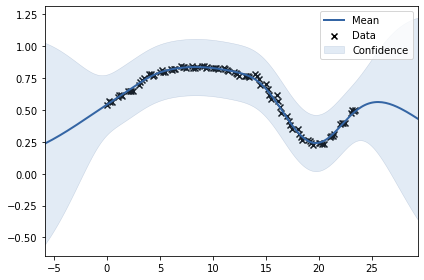

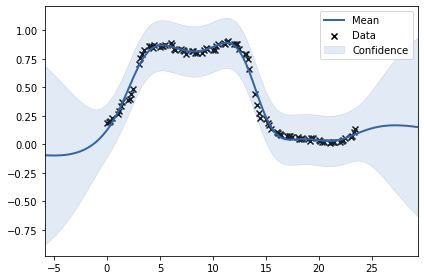

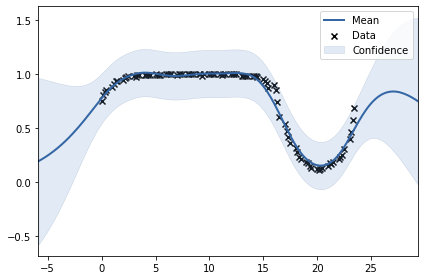

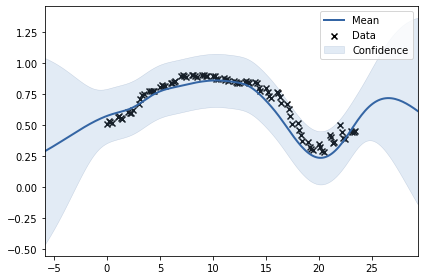

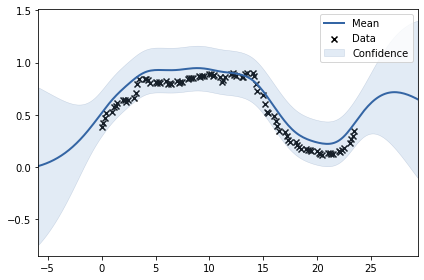

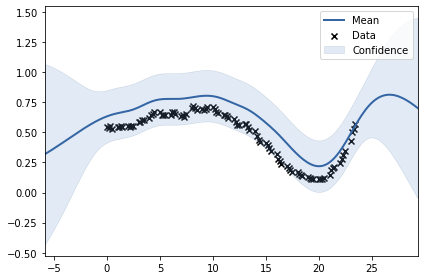

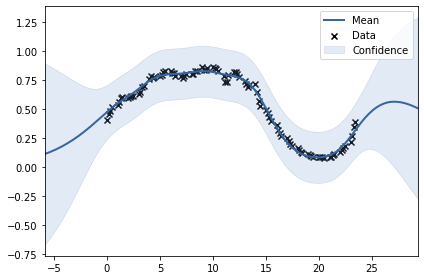

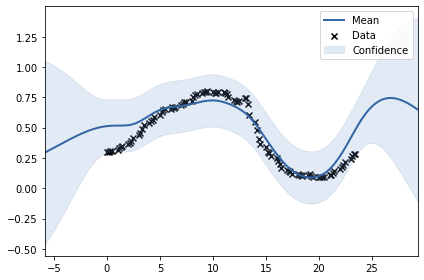

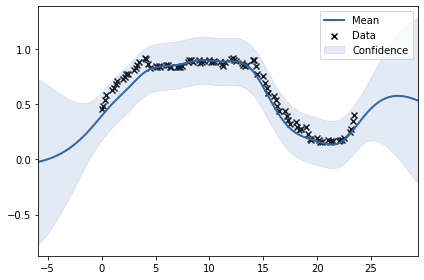

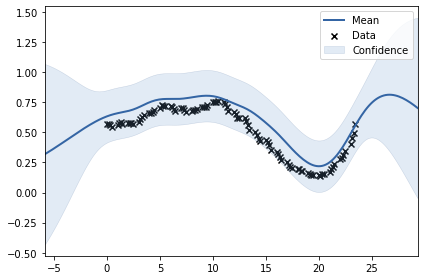

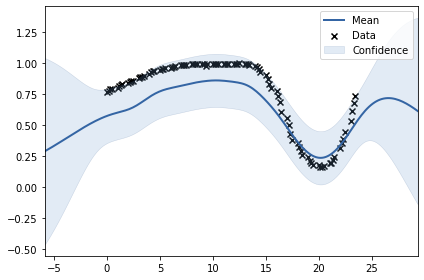

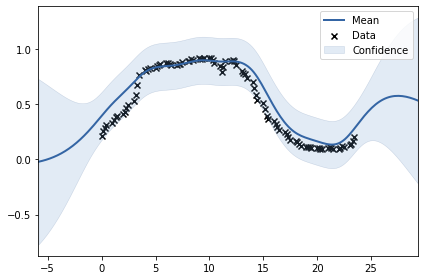

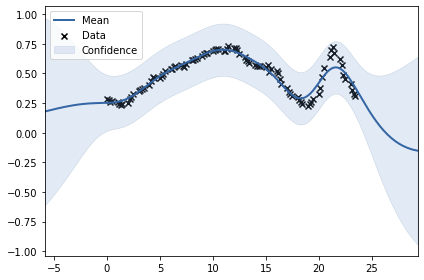

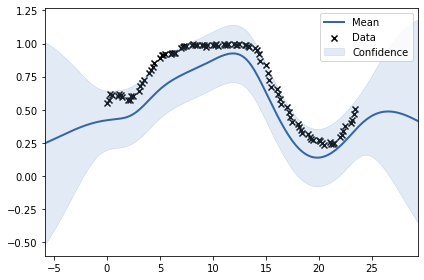

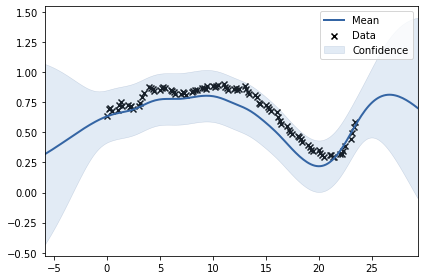

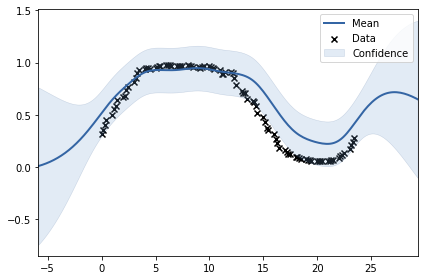

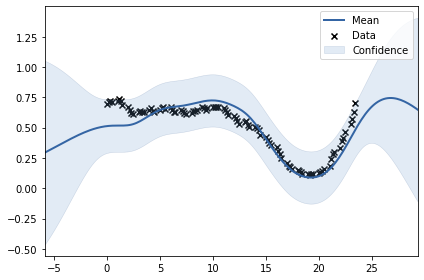

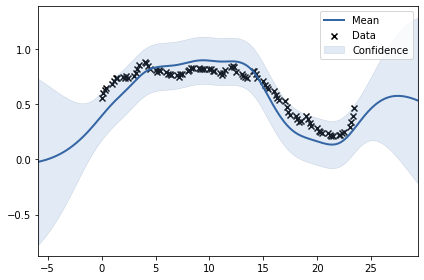

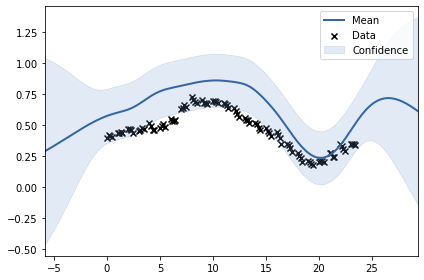

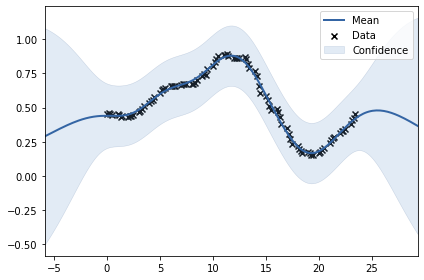

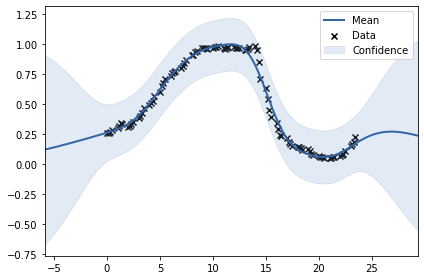

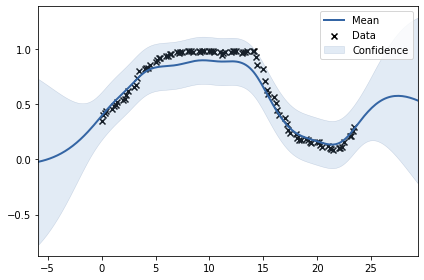

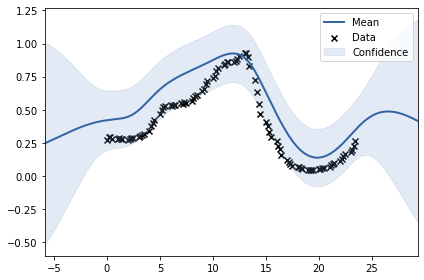

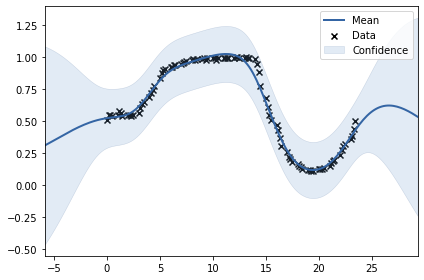

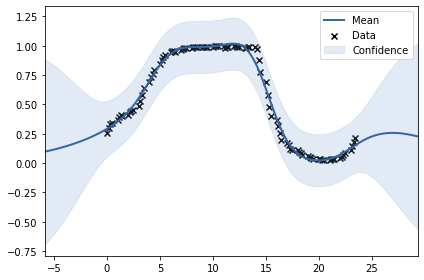

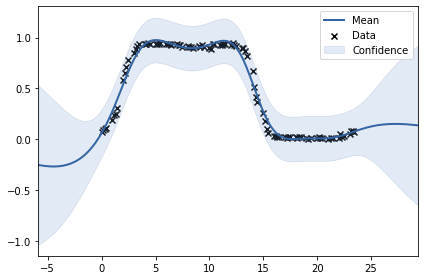

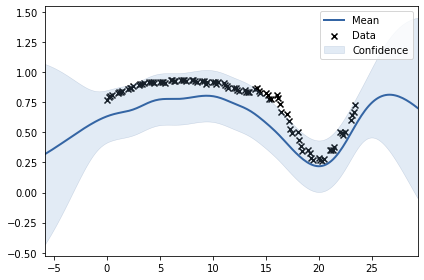

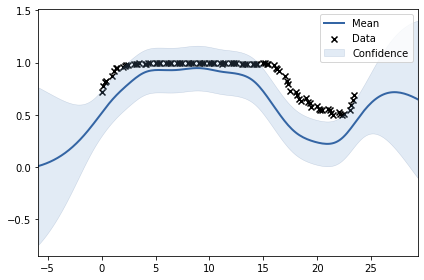

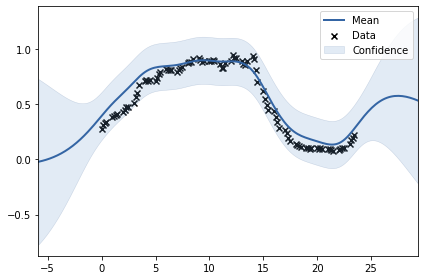

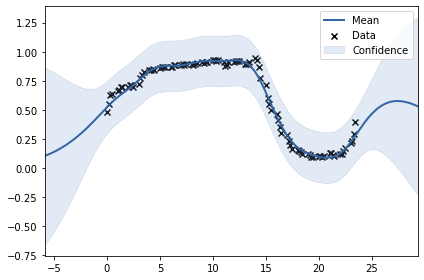

In [13]:
# plot for each geohash the time series and fitted line

for i in df_train['geohash6'].unique():
    data_x = df_train.loc[df_train['geohash6']==i].index.values
    lat = df_train.loc[df_train['geohash6']==i]['latitutde'].unique()[0]
    long = df_train.loc[df_train['geohash6']==i]['longtitude'].unique()[0]
    
    m.plot(fixed_inputs=[(1,lat),(2,long)],which_data_rows=data_x,legend=True)
    print('geohash: ',i, 'lat: ',lat,'long: ',long)

 C:\Users\david\Anaconda3\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x183d3b9b940>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x183d3de12e8>]}

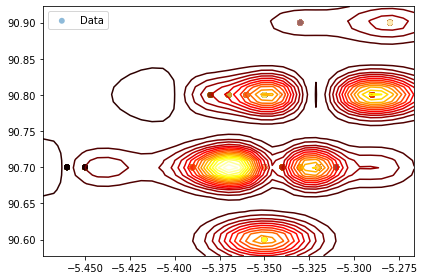

In [14]:
# plot spatial variation at a specific time

time = 19.00
m.plot(fixed_inputs=[(0,time)],which_data_ycols=[0])

In [15]:
# create test data set using data from last day in dataset from 14:00 to 15:00

start = 14.00 
end = 15.00

df_test = df.loc[(df['day']==61) & (df['timestamp']>start-0.01) &(df['timestamp']<end),:]
print(len(df_test))

df_test =df_test.reset_index(drop=True)
df_test.head()

3307


,geohash6,day,timestamp,demand,coordinates,latitutde,longtitude
0,qp096z,61,14.00,0.917029,"(-5.36, 90.8)",-5.36,90.8
1,qp09cg,61,14.15,0.317152,"(-5.3, 90.8)",-5.30,90.8
2,qp09v0,61,14.00,0.626274,"(-5.31, 90.9)",-5.31,90.9
3,qp0d1h,61,14.45,0.114134,"(-5.25, 90.8)",-5.25,90.8
4,qp092r,61,14.00,0.152146,"(-5.36, 90.7)",-5.36,90.7


In [16]:
# predict data points

x_pred = df_test.loc[:,['timestamp','latitutde','longtitude']].values.reshape(-1,3)
x_pred
y_pred, sigma = m.predict(x_pred)

In [17]:
y_pred

array([[0.80254961],
       [0.60400679],
       [0.64271576],
       ...,
       [0.76522645],
       [0.06279196],
       [0.69021487]])

In [18]:
# calculate RMSE

ygrid = df_test['demand'].values.reshape(-1,1)
Sqerr = np.power(ygrid - y_pred,2)
MSE = np.sum(Sqerr)
rmse = np.sqrt(MSE/ygrid.size)
print ('RMSE = ' +str(rmse))

RMSE = 0.49337477583228245


In [19]:
print(np.concatenate((ygrid, y_pred),axis=1))

[[0.91702887 0.80254961]
 [0.31715222 0.60400679]
 [0.62627383 0.64271576]
 ...
 [0.07852096 0.76522645]
 [0.03589189 0.06279196]
 [0.08381218 0.69021487]]


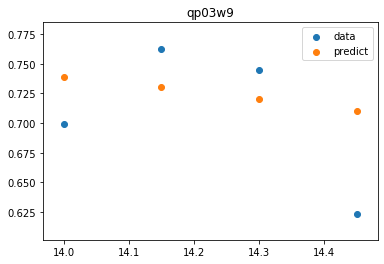

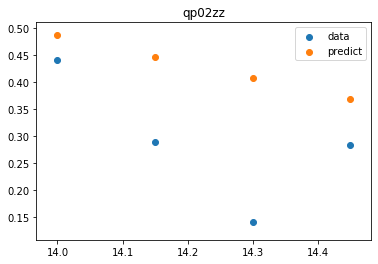

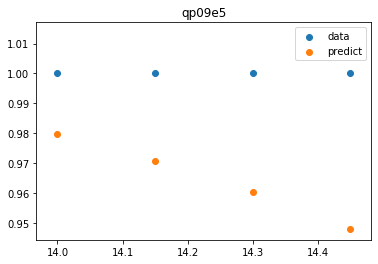

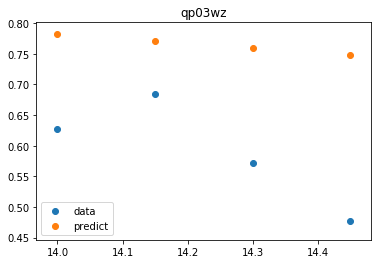

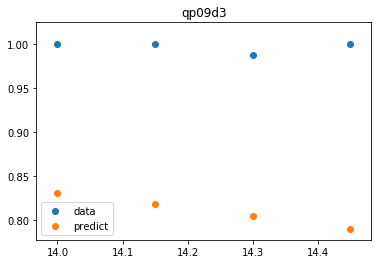

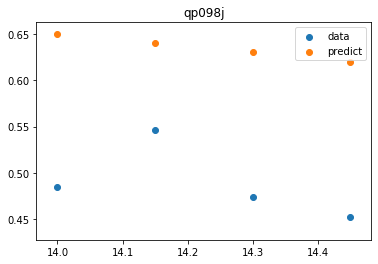

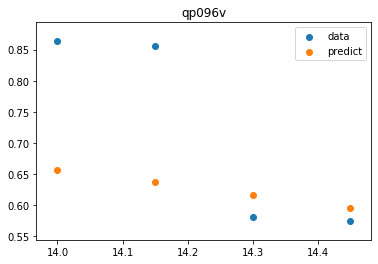

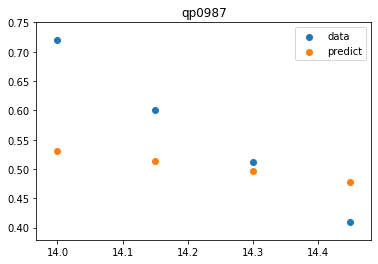

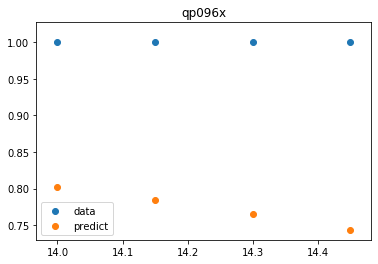

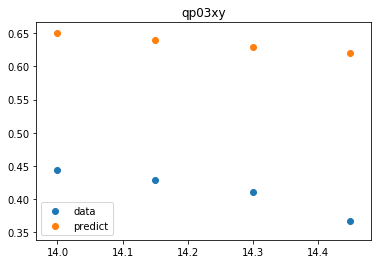

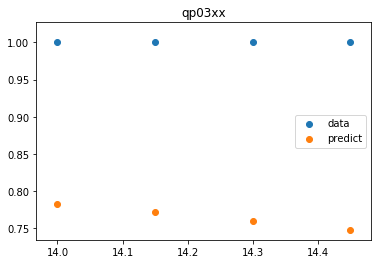

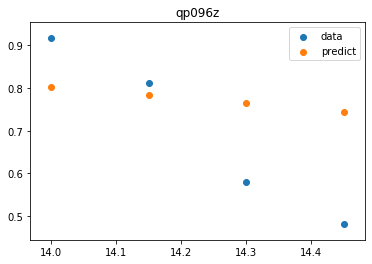

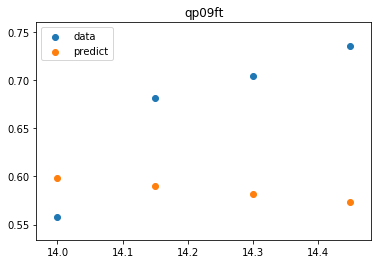

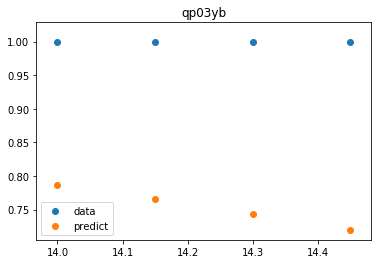

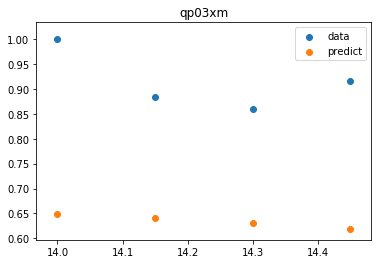

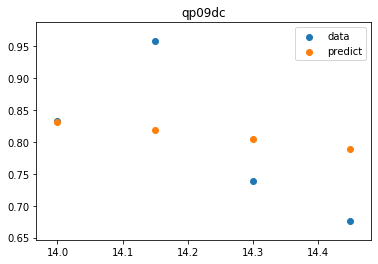

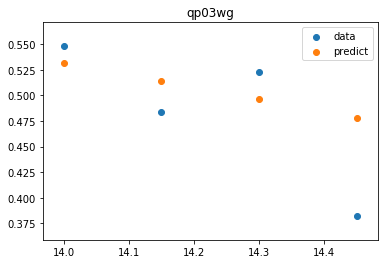

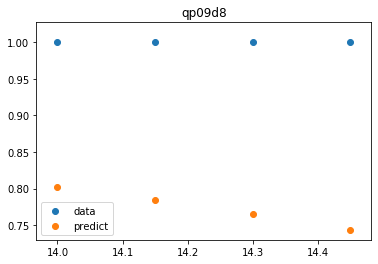

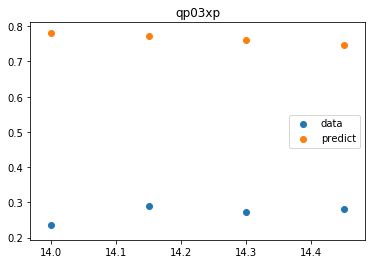

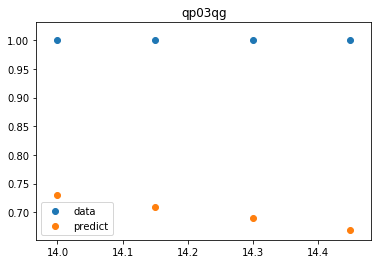

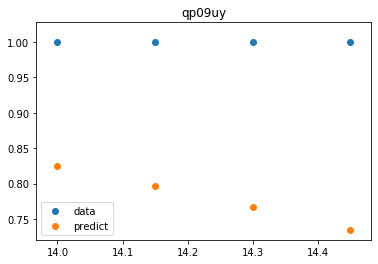

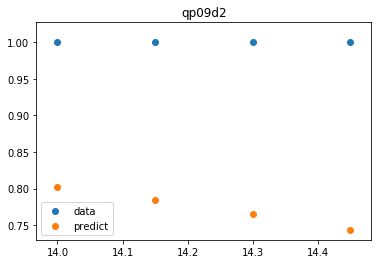

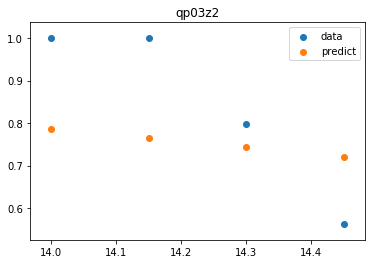

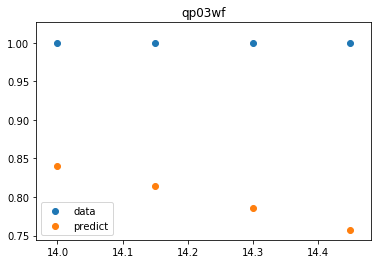

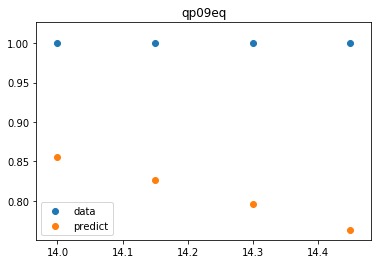

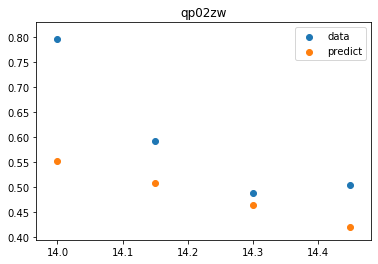

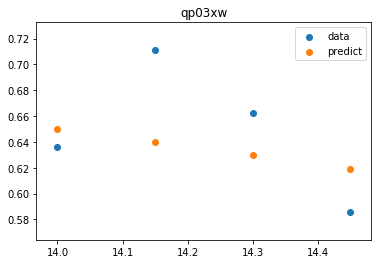

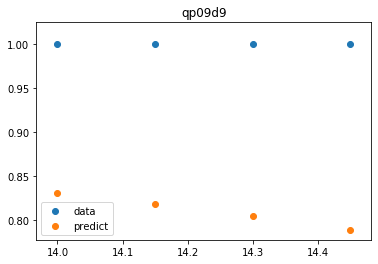

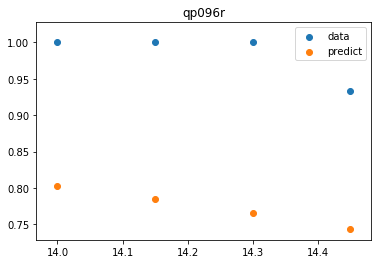

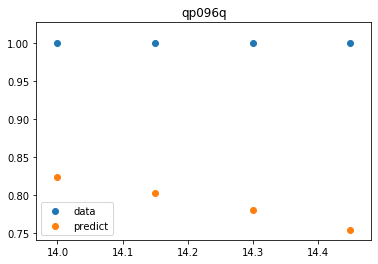

In [20]:
# look at plots of predicted and data for top 30 first

for i in df_train['geohash6'].unique():

    data_x = df_test.loc[df_test['geohash6']==i].index.values
    pred = y_pred[data_x]
    data_y = df_test.loc[df_test['geohash6']==i]['demand']
    x= df_test.loc[df_test['geohash6']==i]['timestamp']
    pred

    plt.scatter(x,data_y,label='data')
    plt.scatter(x,pred,label='predict')
    plt.title(i)
    plt.legend()
    plt.show()

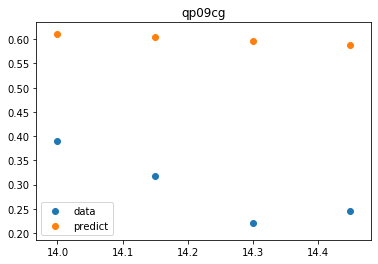

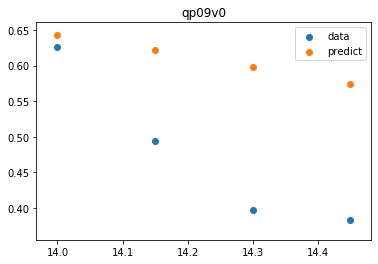

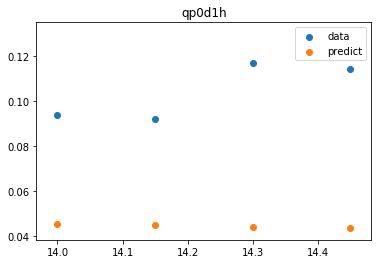

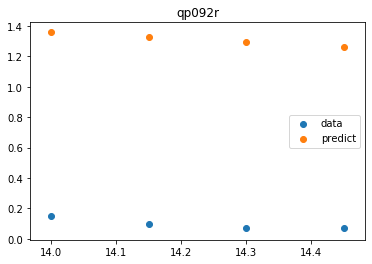

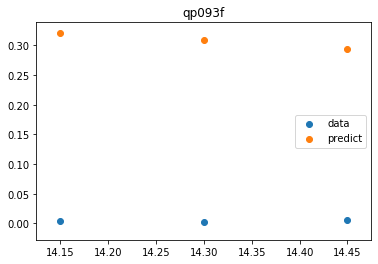

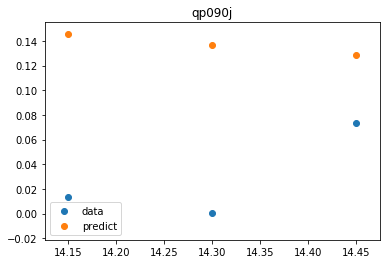

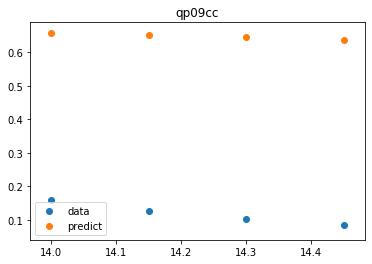

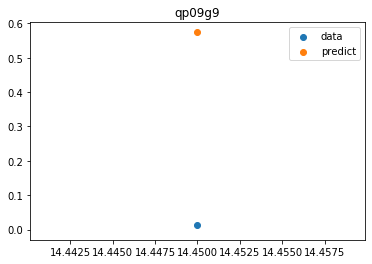

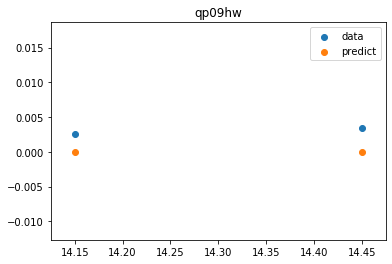

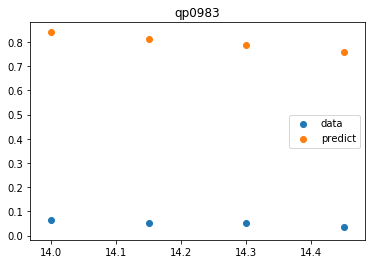

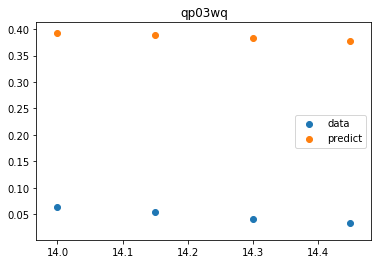

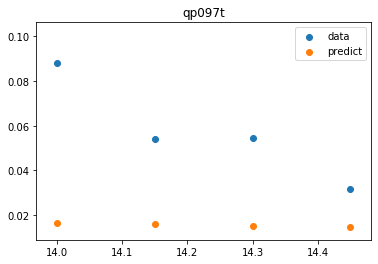

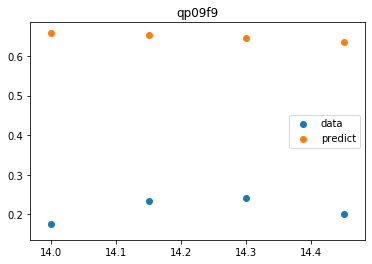

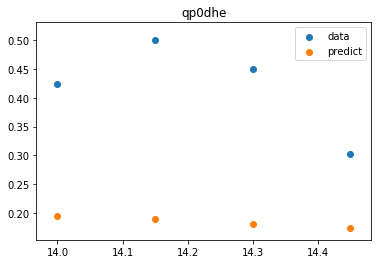

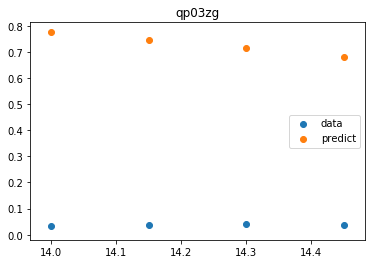

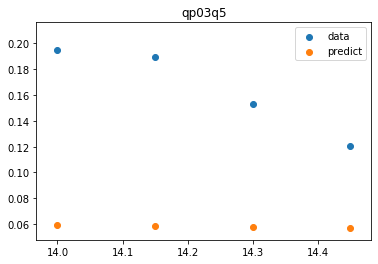

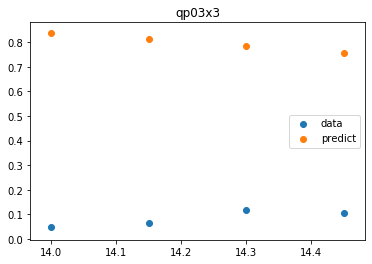

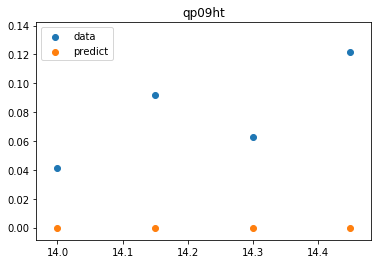

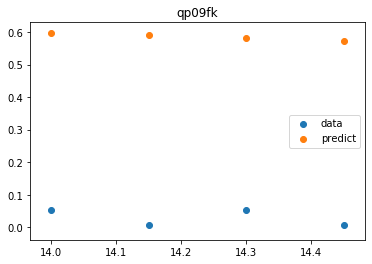

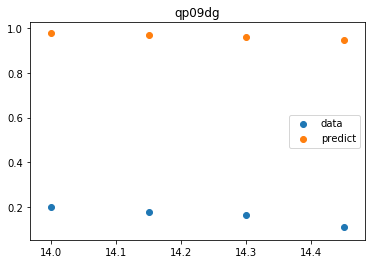

In [21]:
# look at plots for 20 low demand
# not so accurate for these

lowdemand = [x for x in df_test['geohash6'].unique() if x not in df_train['geohash6'].unique()]
lowdemand = lowdemand[:20]
for i in lowdemand:
        
    data_x = df_test.loc[df_test['geohash6']==i].index.values
    pred = y_pred[data_x]
    data_y = df_test.loc[df_test['geohash6']==i]['demand']
    x= df_test.loc[df_test['geohash6']==i]['timestamp']
    pred

    plt.scatter(x,data_y,label='data')
    plt.scatter(x,pred,label='predict')
    plt.title(i)
    plt.legend()
    plt.show()

In [22]:
test = '30demand'
m.pickle(f"output/{test}_model")

**We can try improving the RMSE by increasing number of top demand points used to train the model. <br>
However 30 is chosen because of speed of convergence and cpu power.**


**We can also explore the weekly seasonality. currently only daily seasonality is taken into account**

thanks for reading. jon